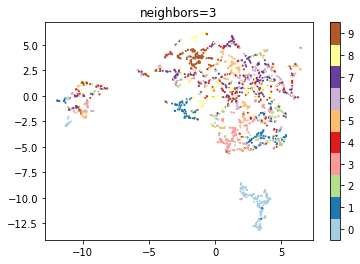

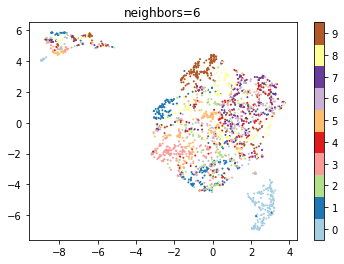

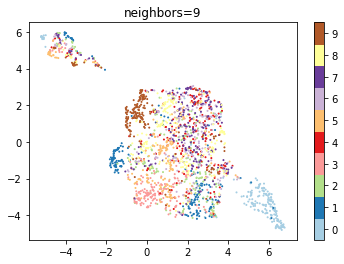

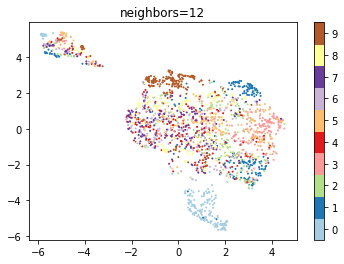

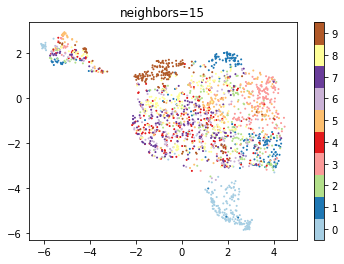

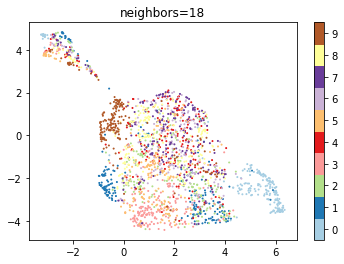

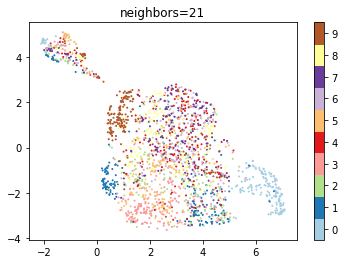

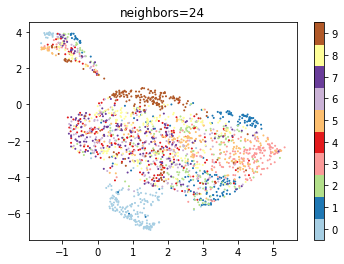

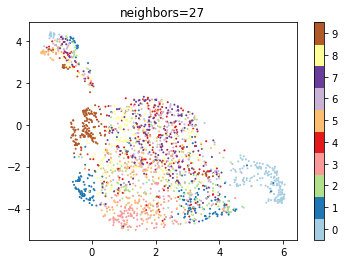

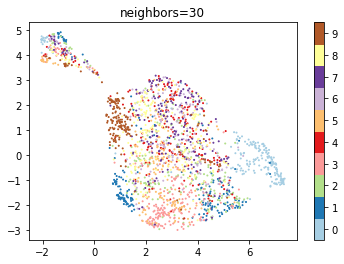

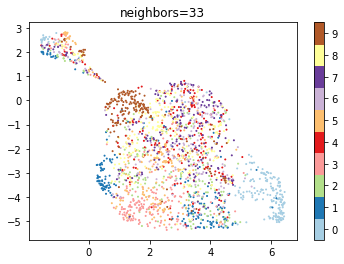

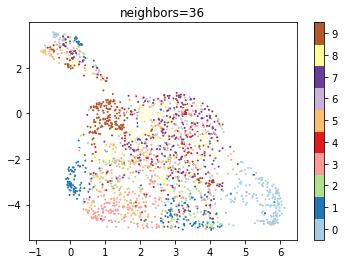

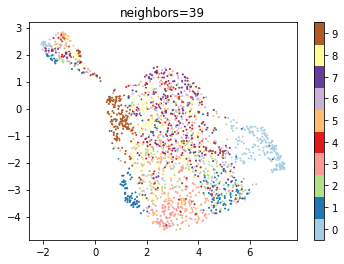

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance 
import sklearn.manifold
import sklearn.datasets
import sklearn.cluster
import umap
#Voy a manejar un dataset con imagenes correspondientes a dígitos en lenguaje de señas particionado en carpetas de
#acuerdo al dígito correspondiente
files_val = glob.glob('./Dataset/*/*.JPG')
datos=len(files_val)
siz=30
Data=np.zeros((datos,siz*siz))
target=np.zeros(datos)
count=0
images=[]
#Función para calcular el brillo
def calculate_brightness(image):
    greyscale_image = image.convert('L')
    histogram = greyscale_image.histogram()
    pixels = sum(histogram)
    brightness = scale = len(histogram)

    for index in range(0, scale):
        ratio = histogram[index] / pixels
        brightness += ratio * (-scale + index)

    return 1 if brightness == 255 else brightness / scale
#Leo los datos por carpetas y asigno el target correspondiente
for i in range(10):
    files_val = glob.glob('./Dataset/'+str(i)+'/*.JPG')
    for names in files_val:
        im=Image.open(names)
        out=(im.convert('L')).resize((siz,siz))
        #Aqui voy a incluir una parte para tratar de normalizar el brillo
        enhancer = ImageEnhance.Brightness(out)
        images.append(enhancer.enhance(0.9/calculate_brightness(out)))
        Data[count,:]=(np.array(out).reshape((-1,1)).T).astype(float)
        target[count]=i
        count=count+1

for neig in np.arange(3,40,3):
    reducer = umap.UMAP(n_neighbors=neig)
    reducer.fit(Data)
    embedding = reducer.transform(Data)
    plt.figure()
    plt.title("neighbors="+str(neig))
    plt.scatter(embedding[:,0], embedding[:,1], c=target, cmap='Paired', s=1.0)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.show()

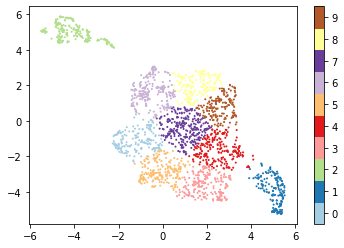

In [6]:
#Realizo KMeans con el mejor valor obtenido de perplexity que parece ser 8
reducer = umap.UMAP(n_neighbors=9)
reducer.fit(Data)
embedding = reducer.transform(Data)
n_clusters = 10
k_means = sklearn.cluster.KMeans(n_clusters=n_clusters)
k_means.fit(embedding) # training
cluster = k_means.predict(embedding) # predice a cual cluster corresponde cada elmento
distance = k_means.transform(embedding)
plt.scatter(embedding[:,0], embedding[:,1], c=cluster, cmap='Paired', s=1.0)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

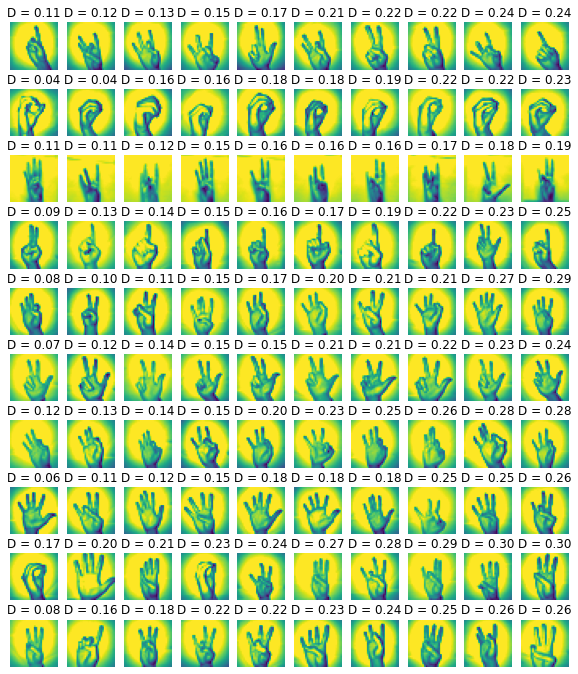

In [7]:
#Realizo la gráfica de los elementos mas cercanos al centro de cada cluster
plt.figure(figsize=(10,12))
for i in range(n_clusters):
    ii = np.argsort(distance[:,i]) # es el orden de los objetos de menor a mayor a la distancia de su cluster
    n_seq = 10
    for l, ind in enumerate(ii[:n_seq]):
        plt.subplot(n_clusters,n_seq,i*n_seq +l +1)
        plt.imshow(images[ind])
        plt.title("D = {:.2f}".format(distance[ind,i]))
        plt.axis('off')
    plt.savefig("Dedos.png")

In [ ]:
#A pesar de realizar una estandarización en las imagenes se ve que se forman grupos que no reflejan 
#la categorización que deseamos. El código percibe estructura pero no es exactamente la que necesitamos. 
#Por ejemplo, siempre se forma un grupo donde el fondo es totalmente de un solo tono sin importar que dígito se esta mostrando.
